In [1]:
import torch, torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# transform the image dataset to PyTorch tensors and Normalize it using mean and std.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# download dataset
train_ds = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root='data', train=False, download=True, transform=transform)

100.0%
100.0%
100.0%
100.0%


In [3]:
print(train_ds)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


60000 10000


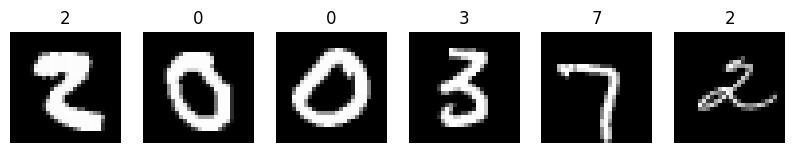

In [9]:
print(len(train_ds), len(test_ds))   # 60000, 10000
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=1000, shuffle=False)

# visualize 6 images
examples = iter(train_loader)
images, labels = next(examples)
fig, axs = plt.subplots(1,6, figsize=(10,2))
for i in range(6):
    axs[i].imshow(images[i].squeeze(), cmap='gray')
    axs[i].set_title(int(labels[i].item()))
    axs[i].axis('off')
plt.show()

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import random

# reproducibility(without this training might give slightly different results in each run)
torch.manual_seed(42); np.random.seed(42); random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256) #fully connected
        self.drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, 128)
        self.out = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

model = MLP().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def train_epoch(loader):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        preds = out.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)
    return total_loss/total, correct/total

def eval_model(loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            total_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)
    return total_loss/total, correct/total

# training loop
epochs = 10
for epoch in range(1, epochs+1):
    train_loss, train_acc = train_epoch(train_loader)
    val_loss, val_acc = eval_model(test_loader)
    print(f"Epoch {epoch} | train_loss {train_loss:.4f} acc {train_acc:.4f}  | test_loss {val_loss:.4f} acc {val_acc:.4f}")

# save
torch.save(model.state_dict(), 'mlp_mnist.pth')
